In [1]:
## conda requirements
# !conda install --file ../env/byoml_sklearn.environment.yml
# !conda activate byoml_sklearn 
# !pip install -r ../env/byoml_sklearn.requirements.txt
## pip-only requirements:
# !pip install waylay-beta scikit-learn==0.22 seaborn tenacity

In [13]:
from datetime import datetime
from random import random
run_id = f"{datetime.now():%Y-%m-%d}-{1000 * random():04.0f}"
MODEL_NAME=f'tutorial-{run_id}'
PROFILE='dedicated-opossum'
MODEL_NAME

'tutorial-2022-03-28-0313'

In this notebook we will show how you can integrate a scikit-learn model with our platform. We will make use of our Python SDK, which you can install by executing: 

`pip install waylay-beta`

This demo depends on some additional libraries:

`pip install scikit-learn==0.22 seaborn tenacity`

In [3]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_blobs
import seaborn as sns
import matplotlib.pyplot as plt

## Generated dataset

First let's create a dataset generator for a temperature and light sensor consisting of 
* three gaussian blobs with fixed sized around fixed centers 
* a uniform scattering of data, the candidate outliers. 

In [4]:
col_tmp = 'Temperature'
col_amb = 'Light Ambience'
col_src = 'Source'
col_features = [col_tmp, col_amb]

def generate_dataset(samples=300, outliers=0.1):
    blob_data =  make_blobs(
        centers=[[16, 0], [21, 1200], [19, 600]], 
        cluster_std=[[1, 0], [0.5, 150], [0.7, 180]], 
        n_features=2, 
        n_samples=samples
    )
    dataset_blob = pd.DataFrame(blob_data[0], columns=[col_tmp, col_amb])
    dataset_blob[col_src] = 'blob'

    outlier_count = int(outliers * samples)
    outlier_data = np.random.uniform(low=[13, 0], high=[24, 2000], size=(outlier_count,2))
    dataset_outliers = pd.DataFrame(outlier_data, columns=[col_tmp, col_amb])
    dataset_outliers[col_src] = 'uniform'
    
    return dataset_blob.append(dataset_outliers, ignore_index=True).sample(n=samples)



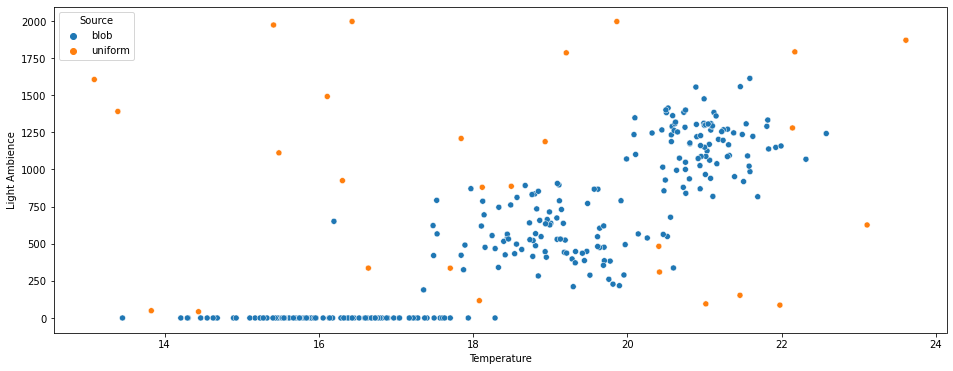

In [5]:
dataset_train = generate_dataset(outliers=0.1)
plt.figure(figsize=(16, 6))
ax = sns.scatterplot(x=col_tmp, y=col_amb, hue=col_src, data=dataset_train)


## Create a model

In this example we will use an IsolationForest to detect outliers, for which later on alarms can be generated.

In [6]:
from sklearn.ensemble import IsolationForest

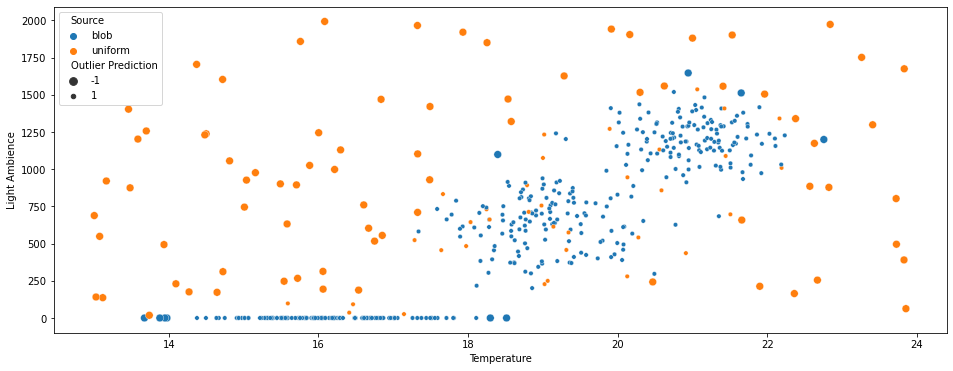

In [7]:
# we use the knowledge that 0.1 of the datapoints are expected to be outliers
model = IsolationForest(contamination=0.1)
model.fit(dataset_train[col_features])

# you could try other sample counts and outlier proportions here ...
dataset_validate = generate_dataset(samples=500, outliers=0.3)
col_predict = 'Outlier Prediction'
dataset_predict = dataset_validate.copy()
dataset_predict[col_predict] = model.predict(dataset_validate[col_features])

plt.figure(figsize=(16, 6))
ax = sns.scatterplot(
    x=col_tmp, y=col_amb,
    hue=col_src, 
    size=col_predict, sizes=[60,20], 
    data=dataset_predict
)

Let's have a look of the performance of this model. 

The sklearn `confusion_matrix` will count expected predictions (whether the datapoint came from the _uniform_ or _blob_ distributions), with the actual classification by the model.

Of course we expect quite some _false negative_ classifications, where samples from the _uniform_ distribution happen to be consistent with the _blobs_.

In [8]:
def report(dataset_predict):
    expected = dataset_predict[col_src].map(lambda x: 1 if x=='blob' else -1)
    predicted = dataset_predict[col_predict]
    from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
    display(pd.DataFrame(
        confusion_matrix(expected, predicted),
        columns=['Detected', 'Not Detected'],
        index=['Uniform', 'Blob']
    ))
    display(pd.DataFrame(
        [
            precision_score(expected,predicted),
            recall_score(expected,predicted),
            f1_score(expected,predicted)
        ],
        columns=['Score'],
        index=['Precision', 'Recall', 'F1']
    ))

report(dataset_predict)

,Detected,Not Detected
Uniform,77,34
Blob,10,379


,Score
Precision,0.917676
Recall,0.974293
F1,0.945137


## Upload and test the model

When the model is ready, we can upload it to the platform. First we need to save it, afterwards we can use the SDK to upload and call it. 
When uploading the model we need to provide some basic information. Like:
- which framework: `sklearn`, `tensorflow`, `pytorch` or `xgboost`
- a name for the model
- the model file (or directory for TensorFlow models)
- an optional description

In [14]:
from waylay import WaylayClient, RestResponseError
waylay = WaylayClient.from_profile(PROFILE)

In [15]:
try:
    waylay.byoml.model.remove(MODEL_NAME)
except RestResponseError as e:
    display(f'Ignored: {e}')

"Ignored: ByomlActionError(404: 'No model with name tutorial-2022-03-28-0313'; DELETE 'https://byoml-io.waylay.io/models/tutorial-2022-03-28-0313')"

In [16]:
waylay.byoml.model.upload(
    model_name=MODEL_NAME, 
    trained_model=model, 
    framework='sklearn', 
    description='isolationforest example'
)

{'createdOn': '2021-01-04T00:00:00+00:00',
 'description': 'isolationforest example',
 'framework': 'sklearn',
 'framework_version': '0.24',
 'message': 'Model successfully uploaded',
 'metadata': {'description': 'isolationforest example'},
 'name': 'tutorial-2022-03-28-0313',
 'updatedOn': '2021-01-04T00:00:00+00:00',
 'version': '1'}

In [18]:
waylay.byoml.model.get(MODEL_NAME)


{'createdBy': 'users/6d686630-0771-4f92-8c63-c888146c33fc',
 'createdOn': '2022-03-28T09:35:11.932000+00:00',
 'description': 'isolationforest example',
 'framework': 'sklearn',
 'framework_version': '0.24',
 'metadata': {'description': 'isolationforest example'},
 'name': 'tutorial-2022-03-28-0313',
 'ready': False,
 'supported_endpoints': [],
 'updatedBy': 'users/6d686630-0771-4f92-8c63-c888146c33fc',
 'updatedOn': '2022-03-28T09:35:23.203000+00:00',
 'version': '1'}

To validate that the local and uploaded model behave the same, we extract a small sample from training data set.

In [19]:
sample = dataset_train[dataset_train[col_src]=='blob'].iloc[0:3]
sample = sample.append(dataset_train[dataset_train[col_src]=='uniform'].iloc[0:3]) 
sample

,Temperature,Light Ambience,Source
223,18.796410,835.014907,blob
147,15.814670,0.000000,blob
176,18.332537,745.396080,blob
319,15.412060,1972.773571,uniform
305,18.932713,1187.455701,uniform
322,17.843935,1208.782399,uniform


Using sample data to test the local model

In [20]:
sample['Local Prediction'] = model.predict(sample[col_features])
sample

,Temperature,Light Ambience,Source,Local Prediction
223,18.796410,835.014907,blob,1
147,15.814670,0.000000,blob,1
176,18.332537,745.396080,blob,1
319,15.412060,1972.773571,uniform,-1
305,18.932713,1187.455701,uniform,-1
322,17.843935,1208.782399,uniform,-1


The same using the model served by BYOML.

Note that it takes a few seconds to activate a new model. SDK actions such as `byoml.model.predict` will retry a few times until the model is ready.

In [21]:
sample['Byoml Prediction'] = waylay.byoml.model.predict(MODEL_NAME, sample[col_features])

sample

,Temperature,Light Ambience,Source,Local Prediction,Byoml Prediction
223,18.796410,835.014907,blob,1,1
147,15.814670,0.000000,blob,1,1
176,18.332537,745.396080,blob,1,1
319,15.412060,1972.773571,uniform,-1,-1
305,18.932713,1187.455701,uniform,-1,-1
322,17.843935,1208.782399,uniform,-1,-1


Let's use the remote model to run on a newly generated dataset, and indicate the outliers predicted by the model.

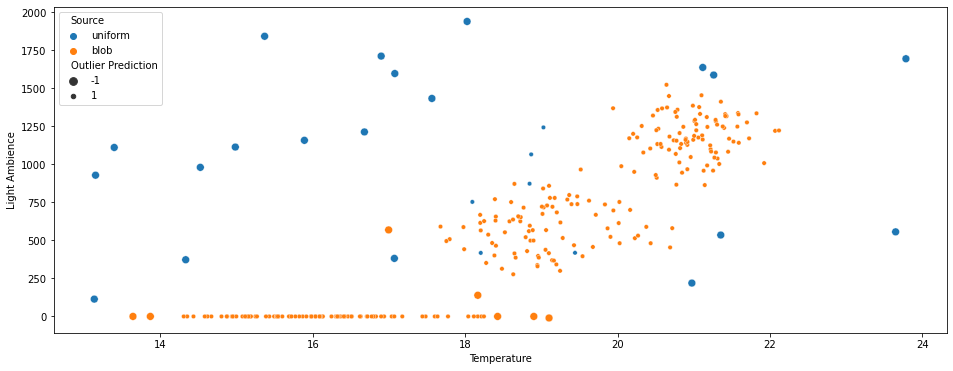

In [22]:
dataset_byoml = generate_dataset()

byoml_prediction = waylay.byoml.model.predict(MODEL_NAME, dataset_byoml[col_features])

dataset_byoml[col_predict] = byoml_prediction

plt.figure(figsize=(16, 6))
ax = sns.scatterplot(
    x=col_tmp, y=col_amb, hue=col_src, size=col_predict, sizes=[60,20], data=dataset_byoml
)

## Upload and test with a Data Query

In the example above we created a toy dataset, but in real world use cases, you probably want to use data already available in Waylay. 

Let's simulate that by first uploading 10 weeks of data and then use a dedicated Query to fetch the data.

Uploading the dataset above can also be done using the SDK, we will convert it to a timestamped dataset first:

In [23]:
data_until = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
upload_count= 10 * 7 * 24 

dataset_import = generate_dataset(upload_count)
data_until
index = pd.date_range(end=data_until, periods=upload_count, freq='1H')

dataset_import = dataset_import.set_index(index)
dataset_import

,Temperature,Light Ambience,Source
2022-01-17 01:00:00,16.469313,0.000000,blob
2022-01-17 02:00:00,15.579344,0.000000,blob
2022-01-17 03:00:00,20.033546,714.741159,blob
2022-01-17 04:00:00,21.000410,1033.951196,blob
2022-01-17 05:00:00,20.095473,645.761055,blob
...,...,...,...
2022-03-27 20:00:00,21.331010,1102.416899,blob
2022-03-27 21:00:00,21.573780,1306.836688,blob
2022-03-27 22:00:00,17.719119,0.000000,blob
2022-03-27 23:00:00,15.816777,0.000000,blob


Timeseries data in waylay is normally associated with a _resource_. It is the entity that contains descriptions of the device (or other source) of IoT events. 

The `waylay.api.resource` actions let you manage these _resources.


In [24]:
resource_id = f'byoml-{MODEL_NAME}'
waylay.api.resource.update(resource_id, body={
    'id': resource_id,
    'name': resource_id
})

{'id': 'byoml-tutorial-2022-03-28-0313',
 'name': 'byoml-tutorial-2022-03-28-0313'}

Now let's import this data into Waylay using the `waylay.timeseries.etl_tool` for bulk timeseries uploads.

In [25]:
etl_import = waylay.timeseries.etl_tool.prepare_import(
    dataset_import,
    name= f'byoml-{MODEL_NAME}',
    resource=resource_id,
    timestamp_timezone='UTC'
)
etl_import = waylay.timeseries.etl_tool.initiate_import(etl_import)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 3.00/3.00 [00:00<00:00, 60.1series/s]


Importing data this way is an asynchronous process. 

Use `waylay.timeseries.etl_tool.check_import` to check on
the progress before continuing.

In [26]:
from IPython.display import HTML
from tenacity import Retrying, stop_after_attempt, wait_fixed

for attempt in Retrying(stop=stop_after_attempt(10),wait=wait_fixed(10)):
    with attempt:

        import_job = waylay.timeseries.etl_tool.check_import(etl_import)

        display(HTML(import_job.to_html()))

        if import_job.status != 'done':
            raise TryAgain

In [27]:
from IPython.display import HTML

import_job = waylay.timeseries.etl_tool.check_import(etl_import)
display(HTML(import_job.to_html()))

Once an ETL upload has been completed, you can remove the import files with `timeseries.etl_tool.cleanup_import`.

In [28]:
import_job = waylay.timeseries.etl_tool.cleanup_import(etl_import)
display(HTML(import_job.to_html()))

After uploading the dataset, we can use it in a Query. 

Let's query the last 7 days directly: 

In [29]:
query_name=f"query-{resource_id}"
query = {
    "window": "P7D",
    "data" : [
        {'resource': resource_id, 'metric': column}
        for column in col_features
    ]
}
waylay.analytics.query.execute(body=query)

resource                  byoml-tutorial-2022-03-28-0313               
metric                                       Temperature Light Ambience
timestamp                                                              
2022-03-21 10:00:00+00:00                      19.089352     778.936302
2022-03-21 11:00:00+00:00                      18.705569     670.787739
2022-03-21 12:00:00+00:00                      16.235870       0.000000
2022-03-21 13:00:00+00:00                      16.227351       0.000000
2022-03-21 14:00:00+00:00                      18.135615     840.911689
...                                                  ...            ...
2022-03-27 20:00:00+00:00                      21.331010    1102.416899
2022-03-27 21:00:00+00:00                      21.573780    1306.836688
2022-03-27 22:00:00+00:00                      17.719119       0.000000
2022-03-27 23:00:00+00:00                      15.816777       0.000000
2022-03-28 00:00:00+00:00                      21.065857    1052.092002

[159 rows x 2 columns]

We'll save this query under a name, so that we can reuse it. 

In [30]:
query_name=f"query-{resource_id}"
waylay.analytics.query.replace(query_name, body={
    'query': query
})
waylay.analytics.query.get(query_name)

{'data': [{'metric': 'Temperature',
   'resource': 'byoml-tutorial-2022-03-28-0313'},
  {'metric': 'Light Ambience', 'resource': 'byoml-tutorial-2022-03-28-0313'}],
 'window': 'P7D'}

You can still override the properties of the query when executing them with `waylay.analytics.query.data`.

<AxesSubplot:xlabel='timestamp'>

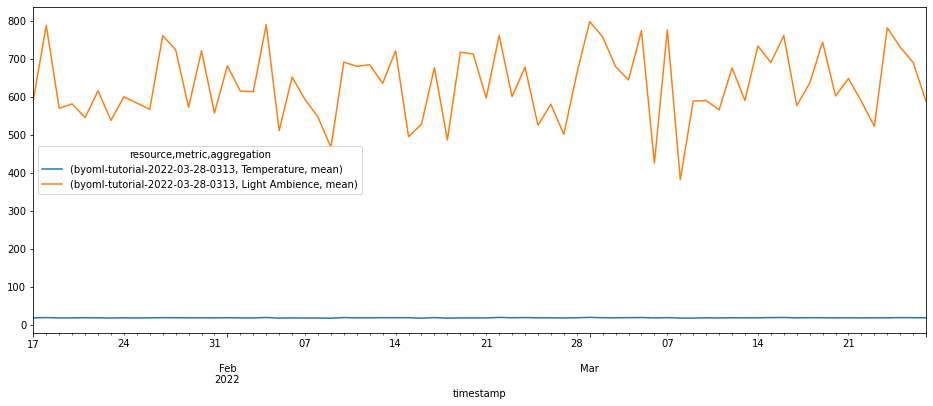

In [31]:
waylay.analytics.query.data(
    query_name, params={ 'window': 'P70D', 'aggregation': 'mean', 'freq': 'P1D' }
).plot(figsize=(16, 6))

Let's use this to select a new training set and validation set for our model

In [32]:
data_previous_month = waylay.analytics.query.data(query_name, params={'window': 'P30D', 'until': '-P30D'})
data_previous_month

resource                  byoml-tutorial-2022-03-28-0313               
metric                                       Temperature Light Ambience
timestamp                                                              
2022-01-27 10:00:00+00:00                      18.507524     777.117870
2022-01-27 11:00:00+00:00                      20.505471    1245.720889
2022-01-27 12:00:00+00:00                      18.800265     475.791368
2022-01-27 13:00:00+00:00                      23.870737     308.672621
2022-01-27 14:00:00+00:00                      19.790104    1110.327323
...                                                  ...            ...
2022-02-26 05:00:00+00:00                      16.482929       0.000000
2022-02-26 06:00:00+00:00                      21.212455    1236.522080
2022-02-26 07:00:00+00:00                      21.280385    1150.008588
2022-02-26 08:00:00+00:00                      20.637291    1236.643237
2022-02-26 09:00:00+00:00                      17.971984     740.421050

[720 rows x 2 columns]

In [33]:
data_last_week = waylay.analytics.query.data(query_name, params={ 'until': '-P1D' })
data_last_week

resource                  byoml-tutorial-2022-03-28-0313               
metric                                       Temperature Light Ambience
timestamp                                                              
2022-03-20 10:00:00+00:00                      16.598805       0.000000
2022-03-20 11:00:00+00:00                      16.214290       0.000000
2022-03-20 12:00:00+00:00                      16.676720    1594.342323
2022-03-20 13:00:00+00:00                      21.207496    1109.135202
2022-03-20 14:00:00+00:00                      19.321527     754.834426
...                                                  ...            ...
2022-03-27 05:00:00+00:00                      21.471538    1307.511820
2022-03-27 06:00:00+00:00                      18.684772     548.055274
2022-03-27 07:00:00+00:00                      20.586129    1124.893443
2022-03-27 08:00:00+00:00                      19.178816     559.795316
2022-03-27 09:00:00+00:00                      14.275571    1376.055303

[168 rows x 2 columns]

We can now do the same as we did above, but now using data directly from Waylay, which will also help when we make a rule with this model and Query.

In [34]:
model = IsolationForest()
model.fit(data_previous_month)

waylay.byoml.model.replace(
    model_name=MODEL_NAME, 
    trained_model=model, 
    framework='sklearn', 
    description='isolationforest example'
)

{'createdOn': '2021-01-04T00:00:00+00:00',
 'description': 'isolationforest example',
 'framework': 'sklearn',
 'framework_version': '0.24',
 'message': 'Model successfully uploaded',
 'metadata': {'description': 'isolationforest example'},
 'name': 'tutorial-2022-03-28-0313',
 'updatedOn': '2021-01-04T00:00:00+00:00',
 'version': '2'}

We can now grab other data to do the validation:

In [35]:
waylay.byoml.model.predict(MODEL_NAME, data_last_week)

array([ 1,  1, -1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,
       -1, -1,  1,  1,  1,  1, -1,  1, -1, -1,  1,  1,  1,  1,  1, -1,  1,
        1, -1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1, -1, -1,
       -1,  1,  1,  1, -1, -1,  1,  1, -1,  1,  1,  1, -1, -1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1, -1,  1, -1,  1, -1,  1,  1,  1, -1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1])

In [36]:
data_last_week[col_predict] = waylay.byoml.model.predict(MODEL_NAME, data_last_week)
data_last_week

resource                  byoml-tutorial-2022-03-28-0313                 \
metric                                       Temperature Light Ambience   
timestamp                                                                 
2022-03-20 10:00:00+00:00                      16.598805       0.000000   
2022-03-20 11:00:00+00:00                      16.214290       0.000000   
2022-03-20 12:00:00+00:00                      16.676720    1594.342323   
2022-03-20 13:00:00+00:00                      21.207496    1109.135202   
2022-03-20 14:00:00+00:00                      19.321527     754.834426   
...                                                  ...            ...   
2022-03-27 05:00:00+00:00                      21.471538    1307.511820   
2022-03-27 06:00:00+00:00                      18.684772     548.055274   
2022-03-27 07:00:00+00:00                      20.586129    1124.893443   
2022-03-27 08:00:00+00:00                      19.178816     559.795316   
2022-03-27 09:00:00+00:00                      14.275571    1376.055303   

resource                  Outlier Prediction  
metric                                        
timestamp                                     
2022-03-20 10:00:00+00:00                  1  
2022-03-20 11:00:00+00:00                  1  
2022-03-20 12:00:00+00:00                 -1  
2022-03-20 13:00:00+00:00                  1  
2022-03-20 14:00:00+00:00                  1  
...                                      ...  
2022-03-27 05:00:00+00:00                  1  
2022-03-27 06:00:00+00:00                  1  
2022-03-27 07:00:00+00:00                  1  
2022-03-27 08:00:00+00:00                  1  
2022-03-27 09:00:00+00:00                 -1  

[168 rows x 3 columns]

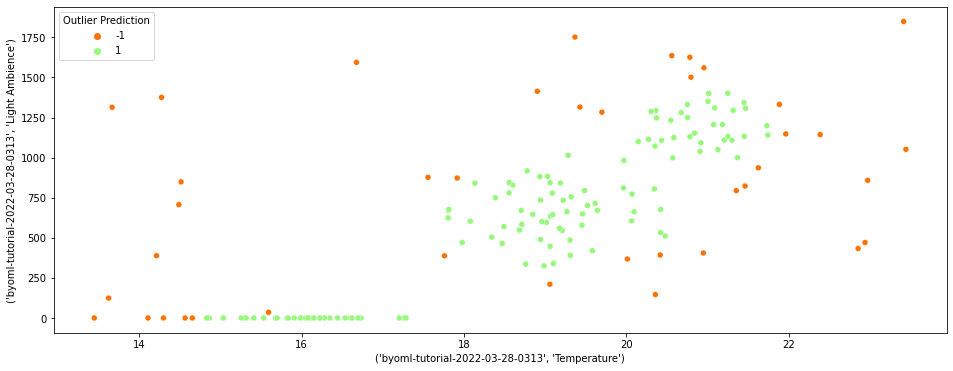

In [37]:
plt.figure(figsize=(16, 6))
cols = data_last_week.columns
ax = sns.scatterplot(
    x=(resource_id, col_tmp),
    y=(resource_id, col_amb),
    hue=col_predict, 
    palette=['xkcd:orange','xkcd:light green'], 
    data=data_last_week
)

#### Cleanup
We delete the entities that were created on the Waylay Platform
* the byoml model
* the query definition
* the waylay resource and its associated data


In [38]:
pd.DataFrame(
    index=['model','resource','query'], 
    data=[MODEL_NAME,resource_id,query_name], 
    columns=['id']
)

,id
model,tutorial-2022-03-28-0313
resource,byoml-tutorial-2022-03-28-0313
query,query-byoml-tutorial-2022-03-28-0313


In [39]:
waylay.analytics.query.remove(query_name)
waylay.api.resource.remove(resource_id)
waylay.byoml.model.remove(MODEL_NAME)

{'message': 'Model tutorial-2022-03-28-0313: all versions deleted',
 'name': 'tutorial-2022-03-28-0313',
 'versions': ['0.0.2']}